## Anomaly Detection in Time Series Data

This is a notebook to do anomaly detection on the NYC Taxi demand dataset.

In [66]:
import numpy as np 
import pandas as pd 


import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import HTML, display


import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import IsolationForest
import logging # TODO: Prints to loggers
import plotly.io as pio

pio.templates.default = "plotly_dark"
pd.options.plotting.backend = "plotly"

In [2]:
df = pd.read_csv('data.csv', parse_dates=['timestamp'])

df.head()

,timestamp,num_passengers
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
# Sort it just to be safe

df = df.sort_values("timestamp")

In [4]:
df.tail()

,timestamp,num_passengers
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591
10319,2015-01-31 23:30:00,26288


## Dataframe Metadata and Basic Checks

In [5]:
df.isna().sum()

timestamp         0
num_passengers    0
dtype: int64

In [6]:
df.dtypes

timestamp         datetime64[ns]
num_passengers             int64
dtype: object

In [7]:
df['timestamp'].min()

Timestamp('2014-07-01 00:00:00')

In [8]:
df['timestamp'].max()

Timestamp('2015-01-31 23:30:00')

In [9]:
# Number of days for this data 
df['timestamp'].max() - df['timestamp'].min()

Timedelta('214 days 23:30:00')

## EDA

In [10]:
df.tail()

,timestamp,num_passengers
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591
10319,2015-01-31 23:30:00,26288


In [11]:
viz_df = df.copy()

In [12]:
viz_df = viz_df.set_index("timestamp")

In [13]:
viz_df.index[:10]

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

### Visualize Demand Across Temporal Components(hourly, daily, weekly, monthly, yearly)

In [51]:
def viz_demand(df, 
               value_column = "num_passengers",
               temp_dim = "hourly"):
    '''
    Visualize Demand Across Temporal Segements
    '''
    valid_tempral_segments = ["hourly",
                              "daily",
                              "weekly",
                              "monthly"]
    segment_mapper = {
        "hourly":"H",
        "daily":"D",
        "weekly":"W",
        "monthly" : "M",        
    }
    if temp_dim not in valid_tempral_segments:
        raise ValueError("Invalid choice for temporal segment. Got `{}`, expected one of these: {}".format(
            temp_dim,
            valid_tempral_segments
        ))

    resampler = segment_mapper[temp_dim]
    return df.resample(resampler)[value_column].sum().plot(title="{} Demand(Number of passengers)".format(
        temp_dim.capitalize()
    ))        

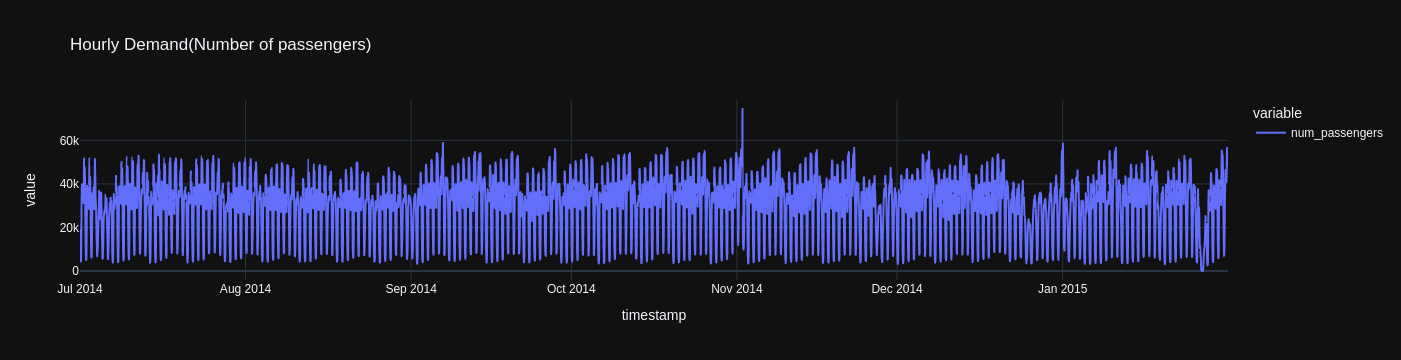

In [52]:
viz_demand(viz_df,temp_dim="hourly")

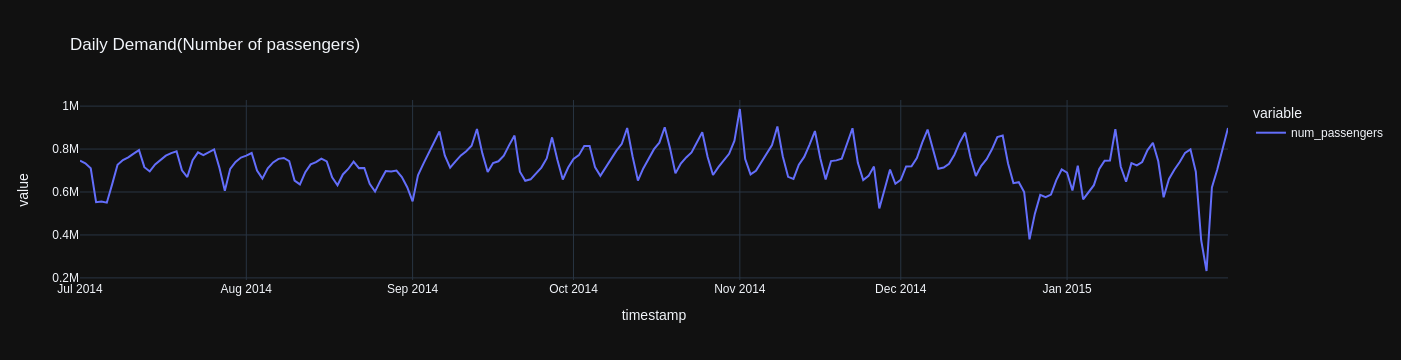

In [44]:
viz_demand(viz_df,temp_dim="daily")

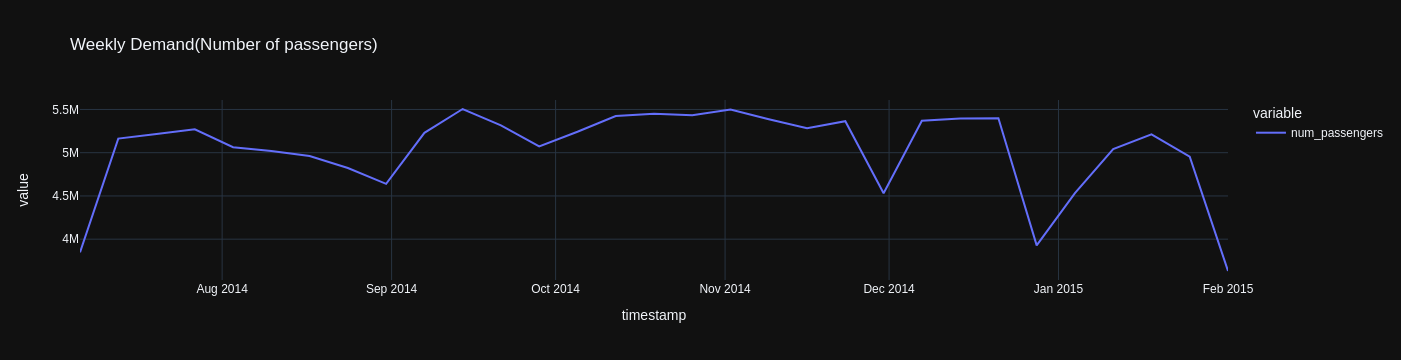

In [45]:
viz_demand(viz_df,temp_dim="weekly")

### Visualizing The Distribution Of The Number of Passengers

Here we check the shape of the distribution of the number of passengers over time. This is the random variable for which we are tring to 
detect anomalies, so it makes sense to "see" what it looks like in the dataset.

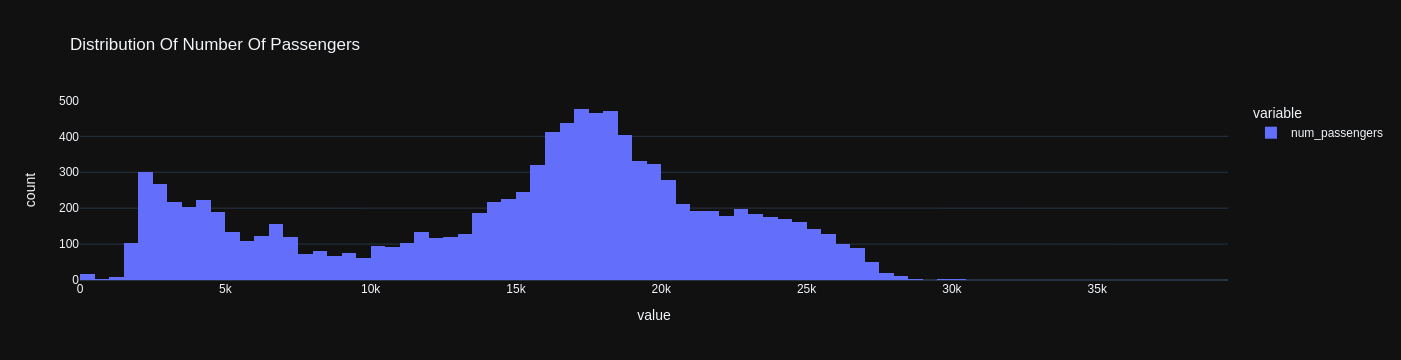

In [49]:
df["num_passengers"].hist(title= "Distribution Of Number Of Passengers")

### Check For Auto Correlation

If there is any correlation between lagged values and current values of number of passengers, this indicates auto-correlation and can be exploited later.

In [155]:
def add_lags(df, 
             lag_column = 'num_passengers',
             n_lags=10):
    df = df.copy()
    for lag in range(1, n_lags + 1):
        col_name = lag_column + "_lag_{}"
        df[col_name.format(lag)] = df[lag_column].shift(lag)
    print("Before dropping NaNs: {}".format(df.shape))
    df = df.dropna()
    print("After dropping NaNs: {}".format(df.shape))
    return df

In [156]:
'''
num_passengers(t) 
num_passengers(t - 30 mins) 
num_passengers(t - 60 mins) 
num_passengers(t - 90mins)
...
...
...
num_passengers(t - n_lags * 30mins)
'''

N_LAGS = 10 #  t-300 mins,t-270mins..... t

lags_df = add_lags(df, n_lags=N_LAGS)

Before dropping NaNs: (10320, 12)
After dropping NaNs: (10310, 12)


In [157]:
lags_df.head()

,timestamp,num_passengers,num_passengers_lag_1,num_passengers_lag_2,num_passengers_lag_3,num_passengers_lag_4,num_passengers_lag_5,num_passengers_lag_6,num_passengers_lag_7,num_passengers_lag_8,num_passengers_lag_9,num_passengers_lag_10
10,2014-07-01 05:00:00,2515,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0,6210.0,8127.0,10844.0
11,2014-07-01 05:30:00,4364,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0,6210.0,8127.0
12,2014-07-01 06:00:00,6526,4364.0,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0,6210.0
13,2014-07-01 06:30:00,11039,6526.0,4364.0,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0
14,2014-07-01 07:00:00,13857,11039.0,6526.0,4364.0,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0


#### Plot Correlation Heatmap

In [158]:
relevant_cols = [col for col in lags_df.columns if "num" in col]
corr_ = lags_df[relevant_cols].corr()
corr_

,num_passengers,num_passengers_lag_1,num_passengers_lag_2,num_passengers_lag_3,num_passengers_lag_4,num_passengers_lag_5,num_passengers_lag_6,num_passengers_lag_7,num_passengers_lag_8,num_passengers_lag_9,num_passengers_lag_10
num_passengers,1.000000,0.970587,0.902166,0.805251,0.693902,0.574274,0.453843,0.332420,0.212511,0.095209,-0.013528
num_passengers_lag_1,0.970587,1.000000,0.970590,0.902173,0.805270,0.693937,0.574320,0.453894,0.332423,0.212424,0.095026
num_passengers_lag_2,0.902166,0.970590,1.000000,0.970592,0.902183,0.805292,0.693970,0.574359,0.453891,0.332339,0.212249
num_passengers_lag_3,0.805251,0.902173,0.970592,1.000000,0.970597,0.902197,0.805317,0.694000,0.574349,0.453805,0.332165
num_passengers_lag_4,0.693902,0.805270,0.902183,0.970597,1.000000,0.970601,0.902210,0.805336,0.693996,0.574294,0.453677
num_passengers_lag_5,0.574274,0.693937,0.805292,0.902197,0.970601,1.000000,0.970604,0.902218,0.805333,0.693962,0.574201
num_passengers_lag_6,0.453843,0.574320,0.693970,0.805317,0.902210,0.970604,1.000000,0.970607,0.902218,0.805320,0.693903
num_passengers_lag_7,0.332420,0.453894,0.574359,0.694000,0.805336,0.902218,0.970607,1.000000,0.970608,0.902219,0.805288
num_passengers_lag_8,0.212511,0.332423,0.453891,0.574349,0.693996,0.805333,0.902218,0.970608,1.000000,0.970608,0.902194
num_passengers_lag_9,0.095209,0.212424,0.332339,0.453805,0.574294,0.693962,0.805320,0.902219,0.970608,1.000000,0.970594


<Axes: >

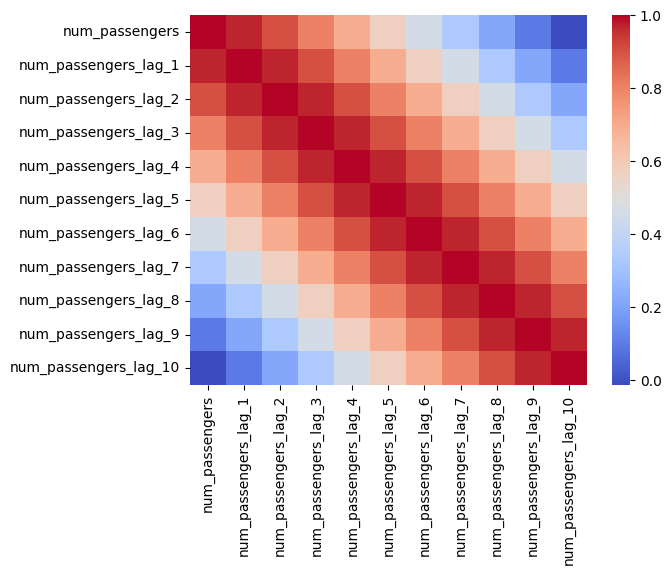

In [159]:
sns.heatmap(corr_,cmap="coolwarm")

Insight! 
There is a high correlation for the values in the last 5 lags(WARM) , for the rest we see the correlation droppping. 
We can use lag features uptil `lag_4` for any new models. 

## Feature Engineering

In [95]:
df.head()

,timestamp,num_passengers
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


### Initializing Features Dataframe

In [105]:
features = df.copy()

#### 1. Adding basic information like hour, day, week, year and month

In [106]:
def add_temporal_column(df, 
                        timestamp_col = "timestamp",
                        column_type="hour"):
    print("Adding temporal column called {}".format(column_type))
    df = df.copy()
    valid_types = ["hour","weekday", "dayofmonth", "month", "year"]
    if column_type not in valid_types:
        raise ValueError("Got {}, expected one of these types {}".format(
          column_type,
            valid_types
        ))
    
    transformations = {
        "hour" : df[timestamp_col].dt.hour,
        "weekday" : df[timestamp_col].dt.weekday,
        "dayofmonth" : df[timestamp_col].dt.day,
        "month" : df[timestamp_col].dt.month,
        "year" : df[timestamp_col].dt.year
    }
    df[column_type] = transformations[column_type]
    return df

In [107]:
temp_cols = ["hour","weekday", "dayofmonth", "month", "year"]
for col in temp_cols:
    features = add_temporal_column(features, column_type=col)

Adding temporal column called hour
Adding temporal column called weekday
Adding temporal column called dayofmonth
Adding temporal column called month
Adding temporal column called year


In [110]:
features.sample(5)

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year
390,2014-07-09 03:00:00,2678,3,2,9,7,2014
1337,2014-07-28 20:30:00,18249,20,0,28,7,2014
1682,2014-08-05 01:00:00,6294,1,1,5,8,2014
9432,2015-01-13 12:00:00,18906,12,1,13,1,2015
870,2014-07-19 03:00:00,13179,3,5,19,7,2014


#### 2. Deviation From Mean Demand during the same hour for the weekday
This feature is about the difference between the mean demand for a particular hour on a weekday vs the observed value for a day.
This is important as in any anomaly we would see a sharp deviation from the norm. 
The assumption here is that for any weekday and hour combination we should expect roughly the same demand .

In [120]:
weekday_hour_mean =  features.groupby(["weekday","hour"])["num_passengers"].mean().to_frame()
weekday_hour_mean.tail()

num_passengers
weekday hour                
6       19      18454.133333
        20      16797.733333
        21      16036.950000
        22      14499.900000
        23      11686.450000

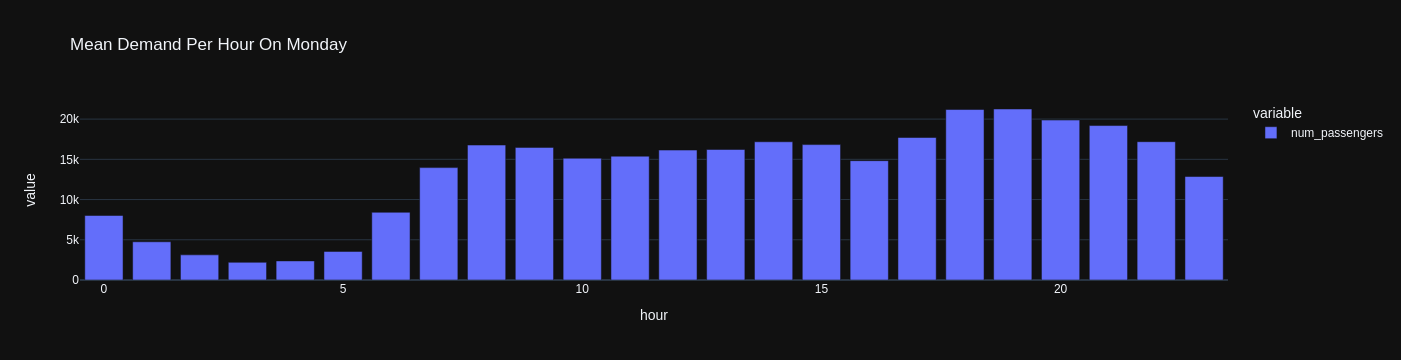

In [129]:
# The mean passenger count on Monday  for each hour
weekday_hour_mean.loc[0].plot(kind="bar",title = "Mean Demand Per Hour On Monday")

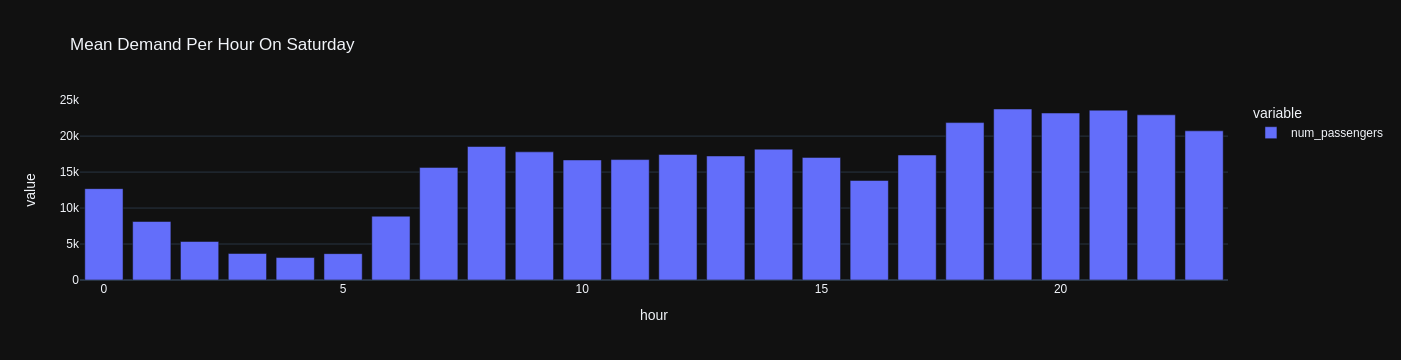

In [227]:
# The mean passenger count on Saturday  for each hour
weekday_hour_mean.loc[3].plot(kind="bar",title = "Mean Demand Per Hour On Saturday")

In [142]:
weekday_hour_mean.tail()

num_passengers
weekday hour                
6       19      18454.133333
        20      16797.733333
        21      16036.950000
        22      14499.900000
        23      11686.450000

In [133]:
features.head()

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year
0,2014-07-01 00:00:00,10844,0,1,1,7,2014
1,2014-07-01 00:30:00,8127,0,1,1,7,2014
2,2014-07-01 01:00:00,6210,1,1,1,7,2014
3,2014-07-01 01:30:00,4656,1,1,1,7,2014
4,2014-07-01 02:00:00,3820,2,1,1,7,2014


In [140]:
features["diff_avg_weekday_hour"] = features.apply(lambda row : row["num_passengers"] - weekday_hour_mean.loc[row["weekday"],row["hour"]]["num_passengers"], axis=1)

In [141]:
features.head()

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year,diff_avg_weekday_hour
0,2014-07-01 00:00:00,10844,0,1,1,7,2014,2360.290323
1,2014-07-01 00:30:00,8127,0,1,1,7,2014,-356.709677
2,2014-07-01 01:00:00,6210,1,1,1,7,2014,1181.806452
3,2014-07-01 01:30:00,4656,1,1,1,7,2014,-372.193548
4,2014-07-01 02:00:00,3820,2,1,1,7,2014,767.887097


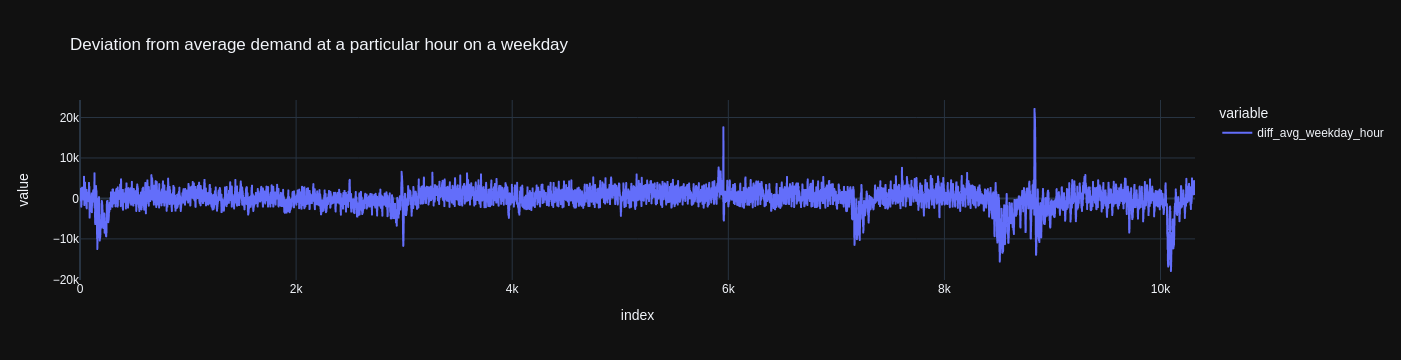

In [144]:
features["diff_avg_weekday_hour"].plot(title = "Deviation from average demand at a particular hour on a weekday")

#### 3. Adding Lagging Features

In [145]:
features.tail()

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year,diff_avg_weekday_hour
10315,2015-01-31 21:30:00,24670,21,5,31,1,2015,2686.758065
10316,2015-01-31 22:00:00,25721,22,5,31,1,2015,1771.048387
10317,2015-01-31 22:30:00,27309,22,5,31,1,2015,3359.048387
10318,2015-01-31 23:00:00,26591,23,5,31,1,2015,1398.483871
10319,2015-01-31 23:30:00,26288,23,5,31,1,2015,1095.483871


In [160]:
features = add_lags(features, 
                    lag_column = 'num_passengers',
                    n_lags = 10)

Before dropping NaNs: (10320, 18)
After dropping NaNs: (10310, 18)


In [162]:
features.head()

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year,diff_avg_weekday_hour,num_passengers_lag_1,num_passengers_lag_2,num_passengers_lag_3,num_passengers_lag_4,num_passengers_lag_5,num_passengers_lag_6,num_passengers_lag_7,num_passengers_lag_8,num_passengers_lag_9,num_passengers_lag_10
10,2014-07-01 05:00:00,2515,5,1,1,7,2014,-692.338710,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0,6210.0,8127.0,10844.0
11,2014-07-01 05:30:00,4364,5,1,1,7,2014,1156.661290,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0,6210.0,8127.0
12,2014-07-01 06:00:00,6526,6,1,1,7,2014,-2050.403226,4364.0,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0,6210.0
13,2014-07-01 06:30:00,11039,6,1,1,7,2014,2462.596774,6526.0,4364.0,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0,4656.0
14,2014-07-01 07:00:00,13857,7,1,1,7,2014,-1457.741935,11039.0,6526.0,4364.0,2515.0,2158.0,2221.0,2064.0,2369.0,2873.0,3820.0


In [163]:
# Add lags for the deviations as well 
features = add_lags(features, 
                    lag_column = 'diff_avg_weekday_hour',
                    n_lags = 10)

Before dropping NaNs: (10310, 28)
After dropping NaNs: (10300, 28)


In [164]:
features.tail()

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year,diff_avg_weekday_hour,num_passengers_lag_1,num_passengers_lag_2,...,diff_avg_weekday_hour_lag_1,diff_avg_weekday_hour_lag_2,diff_avg_weekday_hour_lag_3,diff_avg_weekday_hour_lag_4,diff_avg_weekday_hour_lag_5,diff_avg_weekday_hour_lag_6,diff_avg_weekday_hour_lag_7,diff_avg_weekday_hour_lag_8,diff_avg_weekday_hour_lag_9,diff_avg_weekday_hour_lag_10
10315,2015-01-31 21:30:00,24670,21,5,31,1,2015,2686.758065,23719.0,23291.0,...,1735.758065,1097.241935,2791.241935,3271.129032,4302.129032,4234.370968,2992.370968,3891.370968,1011.370968,2492.177419
10316,2015-01-31 22:00:00,25721,22,5,31,1,2015,1771.048387,24670.0,23719.0,...,2686.758065,1735.758065,1097.241935,2791.241935,3271.129032,4302.129032,4234.370968,2992.370968,3891.370968,1011.370968
10317,2015-01-31 22:30:00,27309,22,5,31,1,2015,3359.048387,25721.0,24670.0,...,1771.048387,2686.758065,1735.758065,1097.241935,2791.241935,3271.129032,4302.129032,4234.370968,2992.370968,3891.370968
10318,2015-01-31 23:00:00,26591,23,5,31,1,2015,1398.483871,27309.0,25721.0,...,3359.048387,1771.048387,2686.758065,1735.758065,1097.241935,2791.241935,3271.129032,4302.129032,4234.370968,2992.370968
10319,2015-01-31 23:30:00,26288,23,5,31,1,2015,1095.483871,26591.0,27309.0,...,1398.483871,3359.048387,1771.048387,2686.758065,1735.758065,1097.241935,2791.241935,3271.129032,4302.129032,4234.370968


#### 4. Add Rolling Window Features For Averages Over Time

Rolling mean of average weekly demand. Window size is 4.   
To use the 30-minute window, this is how we can define the window size. 
2 windows = 1 hour 
24 hours = 48 windows = a day
7 days = 48 * 7  windows = 336 windows = a week 

In [186]:
def rolling_window_mean_feature(df, 
                                value_column = "num_passengers",
                                window_size = 7,
                                min_periods = 1
                               ):
    df = df.copy()
    col_name = "rolling_window_avg_{}".format(window_size)
    df[col_name] = df[value_column].rolling(window_size, min_periods = min_periods).mean()
    print("DF Shape {}".format(df.shape))
    return df

In [187]:
features = rolling_window_mean_feature(features,
                                       window_size=336 )

DF Shape (10300, 29)


In [189]:
features.head()

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year,diff_avg_weekday_hour,num_passengers_lag_1,num_passengers_lag_2,...,diff_avg_weekday_hour_lag_2,diff_avg_weekday_hour_lag_3,diff_avg_weekday_hour_lag_4,diff_avg_weekday_hour_lag_5,diff_avg_weekday_hour_lag_6,diff_avg_weekday_hour_lag_7,diff_avg_weekday_hour_lag_8,diff_avg_weekday_hour_lag_9,diff_avg_weekday_hour_lag_10,rolling_window_avg_336
20,2014-07-01 10:00:00,18984,10,1,1,7,2014,2672.919355,20107.0,19539.0,...,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,-2050.403226,1156.661290,-692.338710,18984.000000
21,2014-07-01 10:30:00,17720,10,1,1,7,2014,1408.919355,18984.0,20107.0,...,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,-2050.403226,1156.661290,18352.000000
22,2014-07-01 11:00:00,17249,11,1,1,7,2014,994.258065,17720.0,18984.0,...,2672.919355,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,-2050.403226,17984.333333
23,2014-07-01 11:30:00,18463,11,1,1,7,2014,2208.258065,17249.0,17720.0,...,1408.919355,2672.919355,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,18104.000000
24,2014-07-01 12:00:00,18908,12,1,1,7,2014,1856.903226,18463.0,17249.0,...,994.258065,1408.919355,2672.919355,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,18264.800000


## Isolation Forest Model

In [190]:
features.head()

,timestamp,num_passengers,hour,weekday,dayofmonth,month,year,diff_avg_weekday_hour,num_passengers_lag_1,num_passengers_lag_2,...,diff_avg_weekday_hour_lag_2,diff_avg_weekday_hour_lag_3,diff_avg_weekday_hour_lag_4,diff_avg_weekday_hour_lag_5,diff_avg_weekday_hour_lag_6,diff_avg_weekday_hour_lag_7,diff_avg_weekday_hour_lag_8,diff_avg_weekday_hour_lag_9,diff_avg_weekday_hour_lag_10,rolling_window_avg_336
20,2014-07-01 10:00:00,18984,10,1,1,7,2014,2672.919355,20107.0,19539.0,...,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,-2050.403226,1156.661290,-692.338710,18984.000000
21,2014-07-01 10:30:00,17720,10,1,1,7,2014,1408.919355,18984.0,20107.0,...,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,-2050.403226,1156.661290,18352.000000
22,2014-07-01 11:00:00,17249,11,1,1,7,2014,994.258065,17720.0,18984.0,...,2672.919355,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,-2050.403226,17984.333333
23,2014-07-01 11:30:00,18463,11,1,1,7,2014,2208.258065,17249.0,17720.0,...,1408.919355,2672.919355,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,2462.596774,18104.000000
24,2014-07-01 12:00:00,18908,12,1,1,7,2014,1856.903226,18463.0,17249.0,...,994.258065,1408.919355,2672.919355,2301.080645,1733.080645,1841.564516,-584.435484,550.258065,-1457.741935,18264.800000


In [196]:
features.isnull().sum().sum()

0

In [194]:
# Set index as timestamp
features = features.set_index('timestamp').dropna()

In [198]:
features.sample(2)

,num_passengers,hour,weekday,dayofmonth,month,year,diff_avg_weekday_hour,num_passengers_lag_1,num_passengers_lag_2,num_passengers_lag_3,...,diff_avg_weekday_hour_lag_2,diff_avg_weekday_hour_lag_3,diff_avg_weekday_hour_lag_4,diff_avg_weekday_hour_lag_5,diff_avg_weekday_hour_lag_6,diff_avg_weekday_hour_lag_7,diff_avg_weekday_hour_lag_8,diff_avg_weekday_hour_lag_9,diff_avg_weekday_hour_lag_10,rolling_window_avg_336
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-24 06:00:00,3225,6,5,24,1,2015,-882.725806,2971.0,3521.0,4822.0,...,-236.887097,-2990.677419,-178.677419,-3303.629032,-1953.629032,-4432.935484,-2020.935484,-1567.241935,567.758065,14949.967262
2014-11-29 16:30:00,16658,16,5,29,11,2014,-769.822581,19125.0,20600.0,19722.0,...,643.016129,-234.983871,150.774194,-661.225806,-454.693548,-663.693548,-1260.548387,-1441.548387,-988.354839,13937.639881


In [199]:
features.columns

Index(['num_passengers', 'hour', 'weekday', 'dayofmonth', 'month', 'year',
       'diff_avg_weekday_hour', 'num_passengers_lag_1', 'num_passengers_lag_2',
       'num_passengers_lag_3', 'num_passengers_lag_4', 'num_passengers_lag_5',
       'num_passengers_lag_6', 'num_passengers_lag_7', 'num_passengers_lag_8',
       'num_passengers_lag_9', 'num_passengers_lag_10',
       'diff_avg_weekday_hour_lag_1', 'diff_avg_weekday_hour_lag_2',
       'diff_avg_weekday_hour_lag_3', 'diff_avg_weekday_hour_lag_4',
       'diff_avg_weekday_hour_lag_5', 'diff_avg_weekday_hour_lag_6',
       'diff_avg_weekday_hour_lag_7', 'diff_avg_weekday_hour_lag_8',
       'diff_avg_weekday_hour_lag_9', 'diff_avg_weekday_hour_lag_10',
       'rolling_window_avg_336'],
      dtype='object')

### Fit  Baseline Model

In [200]:
model = IsolationForest(random_state=42,
                        contamination=0.005,
                        n_estimators=100,
                        n_jobs=-1,
                        max_samples=0.75)

In [201]:
model

IsolationForest(contamination=0.005, max_samples=0.75, n_jobs=-1,
                random_state=42)

In [202]:
model.fit(features)

IsolationForest(contamination=0.005, max_samples=0.75, n_jobs=-1,
                random_state=42)

In [205]:
outlier_predictions = model.predict(features)
outlier_predictions = pd.DataFrame(outlier_predictions, columns=["Outlier"])
outlier_predictions.head()

,Outlier
0,1
1,1
2,1
3,1
4,1


In [211]:
outlier_predictions["Outlier"].value_counts()

Outlier
 1    10248
-1       52
Name: count, dtype: int64

In [214]:
scores = model.decision_function(features)
scores = pd.DataFrame(scores, columns=["Anomaly Score"])

In [216]:
scores.tail()

,Anomaly Score
10295,0.098075
10296,0.088395
10297,0.077694
10298,0.084796
10299,0.095168


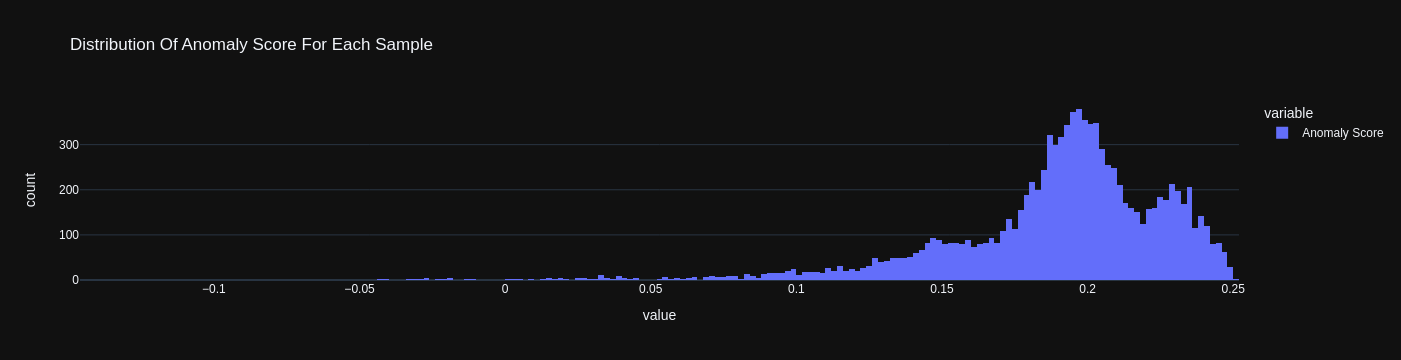

In [217]:
scores.hist(title="Distribution Of Anomaly Score For Each Sample. Lower score indicates more anamolous data")

### Checking Samples Flagged As Anomalies

In [222]:
outlier_idxs = outlier_predictions[outlier_predictions["Outlier"] == -1].index

In [224]:
outlier_idxs

Index([ 5936,  5941,  5942,  8524,  8525,  8814,  8815,  8816,  8817,  8818,
        8819,  8820,  8821,  8822,  8823,  8824,  8825,  8826,  8827,  8828,
        8829,  8830, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057,
       10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067,
       10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085,
       10086, 10087],
      dtype='int64')

In [225]:
df[df.index.isin(outlier_idxs)].sort_values('num_passengers', ascending=False)

,timestamp,num_passengers
5942,2014-11-01 19:00:00,28398
8826,2014-12-31 21:00:00,27804
5941,2014-11-01 18:30:00,27383
8827,2014-12-31 21:30:00,27315
8825,2014-12-31 20:30:00,26779
8824,2014-12-31 20:00:00,25524
8828,2014-12-31 22:00:00,25417
8823,2014-12-31 19:30:00,24368
8829,2014-12-31 22:30:00,23177
8822,2014-12-31 19:00:00,22114


## Next Steps
Next steps that can be done for this:
1. Grid search for the Anomaly detection models.
2. Trying clustering models like DBScan and K-means